# Classificador de Imagens

Classificador de imagens em escala de cinza, utilizando os algoritmos LBP e GLCM como extratores de características.


**Carregar as imagens**  

Carrega as imagens do dataset e as converte para escala de cinza

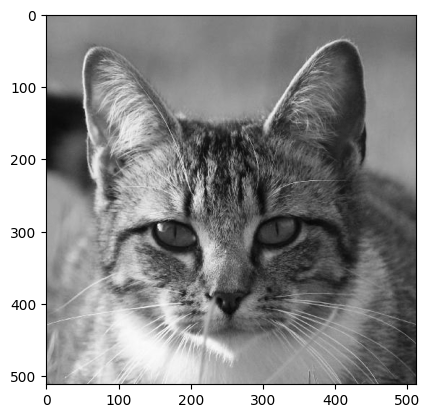

In [1]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.color import rgb2gray, label2rgb
from skimage.transform import rotate
from skimage.feature import local_binary_pattern

images_directory = './images/train'

images = [rgb2gray(img) for img in ski.io.imread_collection(images_directory + '/*.jpg')]

# Display the first image
image = images[0]

plt.imshow(image, cmap=plt.cm.gray)
plt.show()


Text(0.5, 0, 'Intensidade dos pixels')

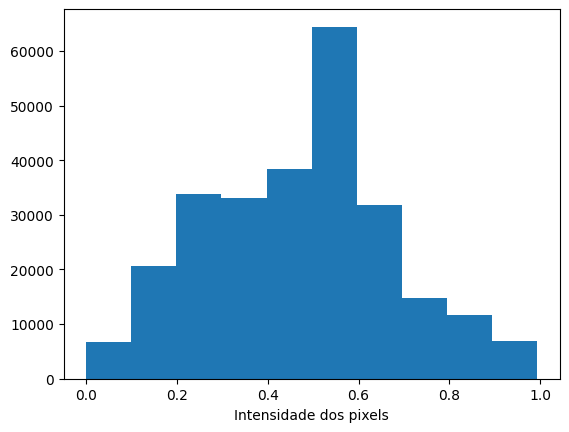

In [2]:
plt.hist(image.ravel())
plt.xlabel('Intensidade dos pixels')

/home/afmireski/Documentos/github/ai/images_classificator/.venv/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Edge Labels range(10, 15)
Flat Labels [0, 1, 2, 22, 23, 24, 25]
Corner Labels [4, 5, 6, 7, 8, 16, 17, 18, 19, 20]
range(10, 15)
[0, 1, 2, 22, 23, 24, 25]
[4, 5, 6, 7, 8, 16, 17, 18, 19, 20]


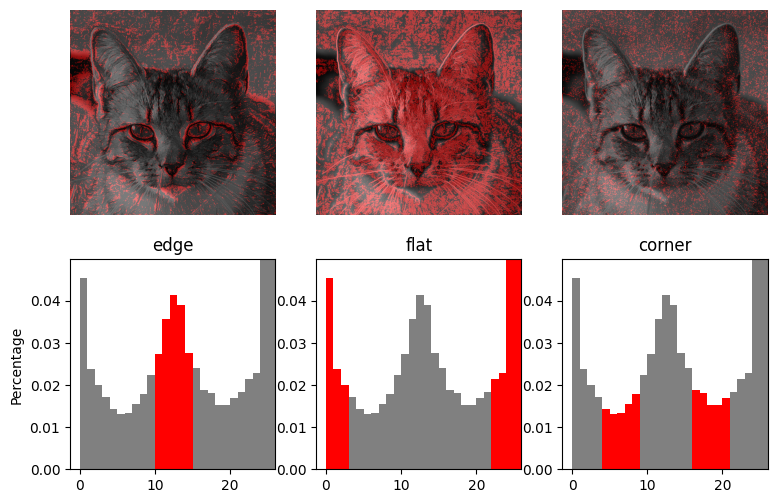

In [6]:

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')

lbp = local_binary_pattern(image, n_points, radius, method='uniform')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(
        lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5'
    )


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4  # 1/4th of the histogram
i_34 = 3 * (n_points // 4)  # 3/4th of the histogram
corner_labels = list(range(i_14 - w, i_14 + w + 1)) + list(
    range(i_34 - w, i_34 + w + 1)
)

label_sets = (edge_labels, flat_labels, corner_labels)

print('Edge Labels', edge_labels)
print('Flat Labels', flat_labels)
print('Corner Labels', corner_labels)

for ax, labels in zip(ax_img, label_sets):
    print(labels)
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')